In [34]:
!pip install scikit-fuzzy scikit-image

In [35]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
import skfuzzy as fuzz
from skimage.measure import label, regionprops
from skimage.metrics import hausdorff_distance

In [36]:
BASE_PATH = "/kaggle/input/raabindata-nucleus-cytoplasm-ground-truths/GrTh"

ORIGINAL = os.path.join(BASE_PATH, "Original")
GROUNDTRUTH = os.path.join(BASE_PATH, "Ground Truth")

cell_types = ["Basophil","Eosinophil","Lymphocyte","Monocyte","Neutrophil"]

In [37]:
files = []

for cell in cell_types:
    paths = glob(os.path.join(ORIGINAL, cell, "**", "*.*"), recursive=True)
    paths = [p for p in paths if p.lower().endswith(('.png','.jpg','.jpeg','.bmp'))]

    for p in paths:
        files.append((cell, p))

print("Total images:", len(files))

Total images: 1145


In [38]:
files = files[:200]

In [39]:
def load_pair(file_tuple):

    cell, img_path = file_tuple
    mask_path = img_path.replace("Original", "Ground Truth")

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, 0)

    img = cv2.resize(img, (224,224))
    mask = cv2.resize(mask, (224,224))

    return img, mask

In [40]:
def split_gt(mask):
    nucleus = (mask == 255).astype(np.uint8)
    cytoplasm = (mask > 0).astype(np.uint8) - nucleus
    return nucleus, cytoplasm

In [41]:
def crop_to_cell(img, n_gt, c_gt):

    wbc = (n_gt + c_gt).astype(np.uint8)

    coords = np.column_stack(np.where(wbc > 0))
    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0)

    return img[y0:y1, x0:x1], n_gt[y0:y1, x0:x1], c_gt[y0:y1, x0:x1]

In [42]:
def kmeans_seg(img, k):
    X = img.reshape((-1,3)).astype(np.float32)
    km = KMeans(n_clusters=k, n_init=10, random_state=42).fit(X)
    return km.labels_.reshape(img.shape[:2])

In [43]:
def fcm_seg(img, k):
    X = img.reshape((-1,3)).T.astype(np.float32)

    centers, membership, _,_,_,_,_ = fuzz.cluster.cmeans(
        X, k, m=2, error=0.005, maxiter=1000
    )
    return centers, membership

In [44]:
def map_clusters(pred, gt_n, gt_c):

    cluster_ids = np.unique(pred)
    nuc_score=[]
    cyt_score=[]

    for c in cluster_ids:
        mask = pred==c
        nuc_score.append(np.sum(mask & gt_n))
        cyt_score.append(np.sum(mask & gt_c))

    n_id = cluster_ids[np.argmax(nuc_score)]
    c_id = cluster_ids[np.argmax(cyt_score)]

    return n_id, c_id

In [45]:
def boundary_f1(pred, gt):

    kernel = np.ones((3,3),np.uint8)

    pred_b = cv2.morphologyEx(pred, cv2.MORPH_GRADIENT, kernel)
    gt_b = cv2.morphologyEx(gt, cv2.MORPH_GRADIENT, kernel)

    tp = np.sum((pred_b==1)&(gt_b==1))
    fp = np.sum((pred_b==1)&(gt_b==0))
    fn = np.sum((pred_b==0)&(gt_b==1))

    precision = tp/(tp+fp+1e-8)
    recall = tp/(tp+fn+1e-8)

    return 2*precision*recall/(precision+recall+1e-8)

In [46]:
def hausdorff(gt, pred):
    if np.sum(gt)==0 or np.sum(pred)==0:
        return np.nan
    return hausdorff_distance(gt, pred)

In [47]:
k_values = [2,3]
thresholds = [0.3,0.4,0.5,0.6,0.7]

results=[]

In [48]:
for k in k_values:

    print(f"\nTesting k = {k}")

    for file in files:

        img, gt = load_pair(file)
        gt_n, gt_c = split_gt(gt)
        img, gt_n, gt_c = crop_to_cell(img, gt_n, gt_c)

        # ---------- KMEANS ----------
        km_labels = kmeans_seg(img, k)
        n_id, c_id = map_clusters(km_labels, gt_n, gt_c)

        km_n = (km_labels==n_id).astype(np.uint8)

        km_f1 = boundary_f1(km_n, gt_n)
        km_hd = hausdorff(gt_n, km_n)

        # ---------- FCM ----------
        centers, membership = fcm_seg(img, k)
        hard_labels = np.argmax(membership, axis=0).reshape(img.shape[:2])
        n_id, c_id = map_clusters(hard_labels, gt_n, gt_c)

        nucleus_prob = membership[n_id].reshape(img.shape[:2])

        for t in thresholds:

            fcm_n = (nucleus_prob > t).astype(np.uint8)

            fcm_f1 = boundary_f1(fcm_n, gt_n)
            fcm_hd = hausdorff(gt_n, fcm_n)

            results.append([
                k, t,
                km_f1, km_hd,
                fcm_f1, fcm_hd
            ])


Testing k = 2

Testing k = 3


In [49]:
df = pd.DataFrame(results, columns=[
    "k","threshold",
    "KM_BoundaryF1","KM_Hausdorff",
    "FCM_BoundaryF1","FCM_Hausdorff"
])

df.head()

,k,threshold,KM_BoundaryF1,KM_Hausdorff,FCM_BoundaryF1,FCM_Hausdorff
0,2,0.3,0.258434,12.165525,0.332724,15.000000
1,2,0.4,0.258434,12.165525,0.293379,12.206556
2,2,0.5,0.258434,12.165525,0.265475,10.630146
3,2,0.6,0.258434,12.165525,0.250235,12.369317
4,2,0.7,0.258434,12.165525,0.251056,12.369317


In [50]:
summary = df.groupby(["k","threshold"]).mean()
summary

KM_BoundaryF1  KM_Hausdorff  FCM_BoundaryF1  FCM_Hausdorff
k threshold                                                            
2 0.3             0.381449     19.036793        0.420461      21.097005
  0.4             0.381449     19.036793        0.402234      20.198017
  0.5             0.381449     19.036793        0.380101      19.178892
  0.6             0.381449     19.036793        0.357234      18.033599
  0.7             0.381449     19.036793        0.330055      16.270344
3 0.3             0.224976     13.035418        0.235364      14.892933
  0.4             0.224976     13.035418        0.217705      13.919544
  0.5             0.224976     13.035418        0.201060      13.310517
  0.6             0.224976     13.035418        0.184319      13.086416
  0.7             0.224976     13.035418        0.165686      13.604973

In [51]:
best = summary["FCM_BoundaryF1"].idxmax()
print("Best Accuracy → k =", best[0], " threshold =", best[1])

best_hd = summary["FCM_Hausdorff"].idxmin()
print("Lowest Error → k =", best_hd[0], " threshold =", best_hd[1])

Best Accuracy → k = 2  threshold = 0.3
Lowest Error → k = 3  threshold = 0.6


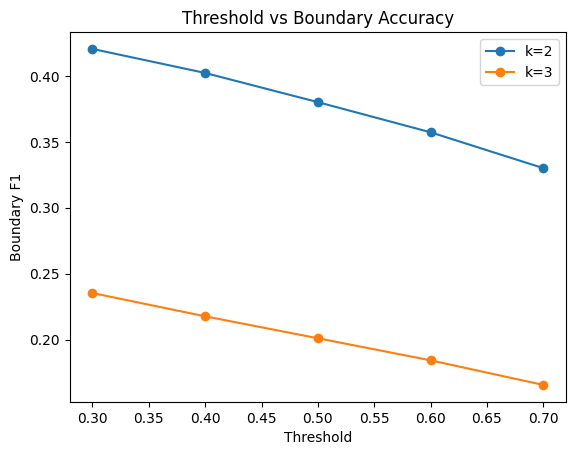

In [52]:
for k in k_values:
    subset = summary.loc[k]
    plt.plot(subset.index, subset["FCM_BoundaryF1"], marker='o', label=f"k={k}")

plt.xlabel("Threshold")
plt.ylabel("Boundary F1")
plt.title("Threshold vs Boundary Accuracy")
plt.legend()
plt.show()

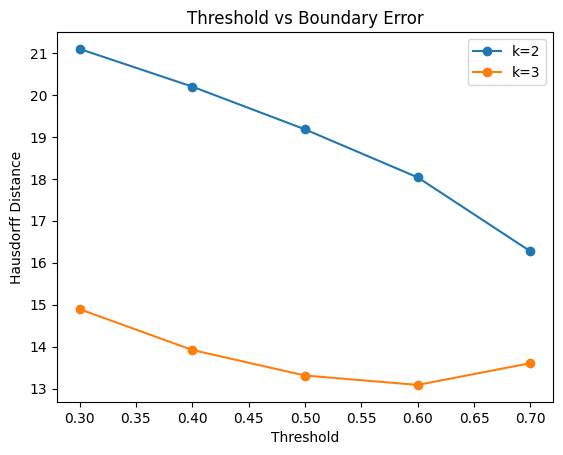

In [53]:
for k in k_values:
    subset = summary.loc[k]
    plt.plot(subset.index, subset["FCM_Hausdorff"], marker='o', label=f"k={k}")

plt.xlabel("Threshold")
plt.ylabel("Hausdorff Distance")
plt.title("Threshold vs Boundary Error")
plt.legend()
plt.show()

In [54]:
def visualize_segmentation(file_tuple, k=3, threshold=0.6):

    img, gt = load_pair(file_tuple)
    gt_n, gt_c = split_gt(gt)
    img, gt_n, gt_c = crop_to_cell(img, gt_n, gt_c)

    # ---------- KMEANS ----------
    km_labels = kmeans_seg(img, k)
    n_id, c_id = map_clusters(km_labels, gt_n, gt_c)
    km_n = (km_labels==n_id).astype(np.uint8)

    # ---------- FCM ----------
    centers, membership = fcm_seg(img, k)
    hard_labels = np.argmax(membership, axis=0).reshape(img.shape[:2])
    n_id, c_id = map_clusters(hard_labels, gt_n, gt_c)

    nucleus_prob = membership[n_id].reshape(img.shape[:2])
    fcm_n = (nucleus_prob > threshold).astype(np.uint8)

    # ---------- soft map ----------
    soft_map = nucleus_prob

    # ---------- boundary overlays ----------
    def overlay(img, mask, color):
        overlay_img = img.copy()
        contours,_ = cv2.findContours(mask.astype(np.uint8),
                                      cv2.RETR_EXTERNAL,
                                      cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(overlay_img, contours, -1, color, 2)
        return overlay_img

    km_overlay = overlay(img, km_n, (0,255,0))
    fcm_overlay = overlay(img, fcm_n, (255,0,0))

    # ---------- plot ----------
    plt.figure(figsize=(16,6))

    plt.subplot(2,3,1)
    plt.imshow(img); plt.title("Original"); plt.axis('off')

    plt.subplot(2,3,2)
    plt.imshow(gt_n,cmap='gray'); plt.title("Ground Truth Nucleus"); plt.axis('off')

    plt.subplot(2,3,3)
    plt.imshow(km_n,cmap='gray'); plt.title("KMeans Nucleus"); plt.axis('off')

    plt.subplot(2,3,4)
    plt.imshow(fcm_n,cmap='gray'); plt.title("FCM Nucleus"); plt.axis('off')

    plt.subplot(2,3,5)
    plt.imshow(soft_map,cmap='hot'); plt.title("FCM Soft Map"); plt.axis('off')

    plt.subplot(2,3,6)
    plt.imshow(fcm_overlay); plt.title("Overlay Boundary"); plt.axis('off')

    plt.tight_layout()
    plt.show()

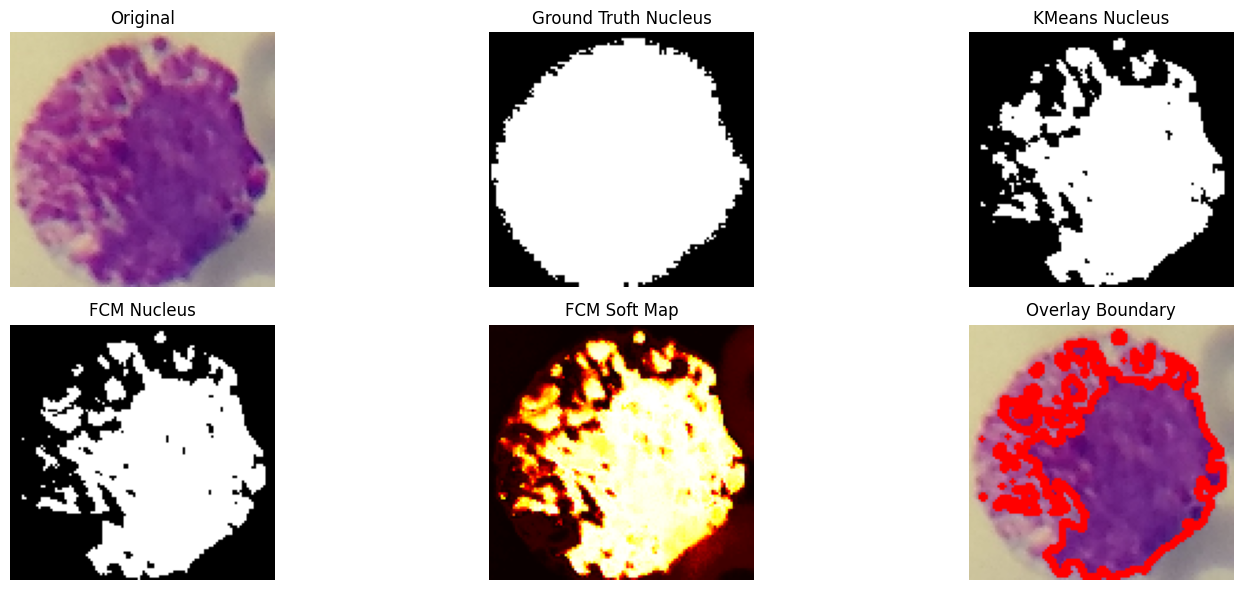

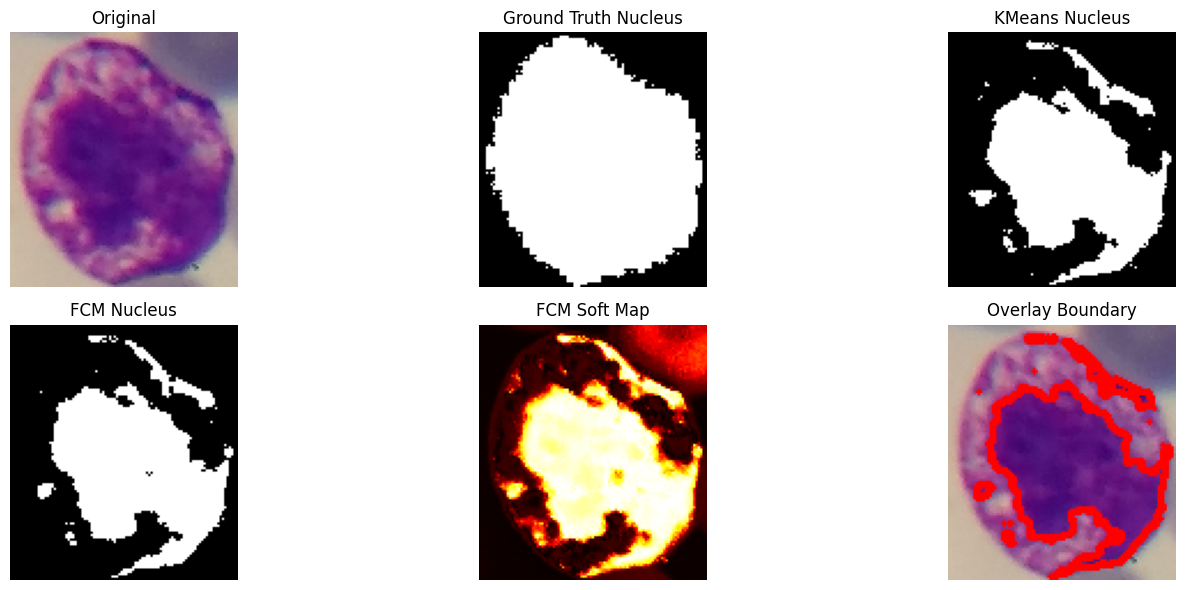

In [68]:
sample_files = files[:2]

for f in sample_files:
    visualize_segmentation(f, k=3, threshold=0.6)

In [56]:
def grid_visualization(file_list, k=3, threshold=0.6):

    plt.figure(figsize=(12, len(file_list)*3))

    for i, file_tuple in enumerate(file_list):

        img, gt = load_pair(file_tuple)
        gt_n, gt_c = split_gt(gt)
        img, gt_n, gt_c = crop_to_cell(img, gt_n, gt_c)

        km_labels = kmeans_seg(img, k)
        n_id, _ = map_clusters(km_labels, gt_n, gt_c)
        km_n = (km_labels==n_id).astype(np.uint8)

        centers, membership = fcm_seg(img, k)
        hard_labels = np.argmax(membership, axis=0).reshape(img.shape[:2])
        n_id, _ = map_clusters(hard_labels, gt_n, gt_c)

        fcm_n = (membership[n_id].reshape(img.shape[:2]) > threshold).astype(np.uint8)

        plt.subplot(len(file_list),3,3*i+1)
        plt.imshow(img); plt.axis('off'); plt.title("Original")

        plt.subplot(len(file_list),3,3*i+2)
        plt.imshow(km_n,cmap='gray'); plt.axis('off'); plt.title("KMeans")

        plt.subplot(len(file_list),3,3*i+3)
        plt.imshow(fcm_n,cmap='gray'); plt.axis('off'); plt.title("FCM")

    plt.tight_layout()
    plt.show()

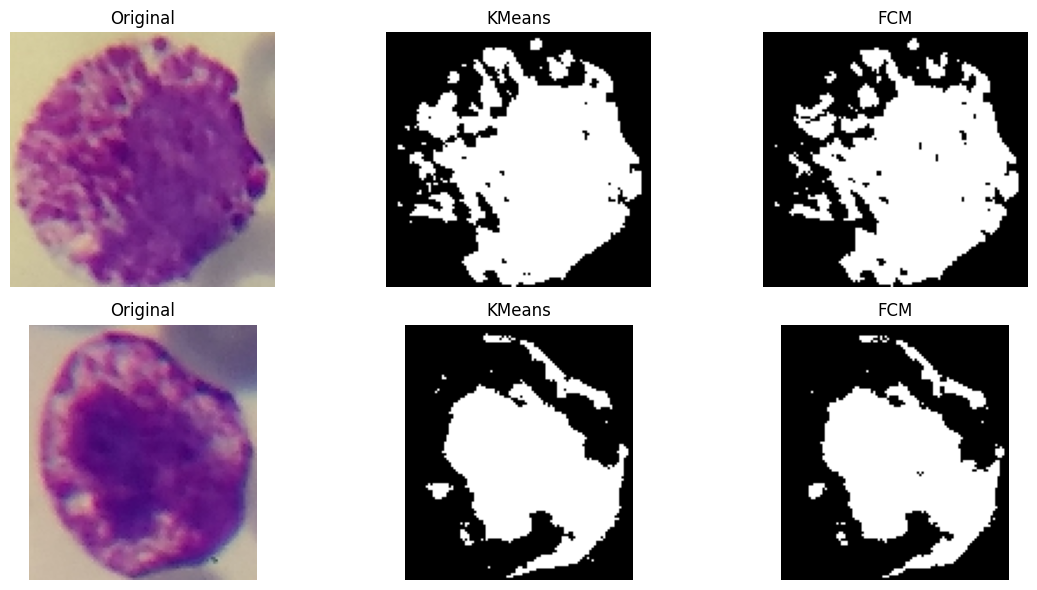

In [67]:
grid_visualization(files[:2])

In [58]:
km_n = (km_labels==n_id).astype(np.uint8)
km_c = (km_labels==c_id).astype(np.uint8)

In [62]:
# run FCM
centers, membership = fcm_seg(img, k)

# get hard cluster labels (to identify cluster IDs)
hard_labels = np.argmax(membership, axis=0).reshape(img.shape[:2])

# map clusters to nucleus & cytoplasm
n_id, c_id = map_clusters(hard_labels, gt_n, gt_c)

# probability maps
nucleus_prob = membership[n_id].reshape(img.shape[:2])
cyto_prob    = membership[c_id].reshape(img.shape[:2])

In [63]:
threshold = 0.6

fcm_n = (nucleus_prob > threshold).astype(np.uint8)
fcm_c = (cyto_prob > threshold).astype(np.uint8)

In [64]:
def visualize_full_segmentation(file_tuple, k=3, threshold=0.6):

    img, gt = load_pair(file_tuple)
    gt_n, gt_c = split_gt(gt)
    img, gt_n, gt_c = crop_to_cell(img, gt_n, gt_c)

    # ---------- KMEANS ----------
    km_labels = kmeans_seg(img, k)
    n_id, c_id = map_clusters(km_labels, gt_n, gt_c)

    km_n = (km_labels==n_id).astype(np.uint8)
    km_c = (km_labels==c_id).astype(np.uint8)

    # ---------- FCM ----------
    centers, membership = fcm_seg(img, k)
    hard = np.argmax(membership, axis=0).reshape(img.shape[:2])
    n_id, c_id = map_clusters(hard, gt_n, gt_c)

    nucleus_prob = membership[n_id].reshape(img.shape[:2])
    cyto_prob = membership[c_id].reshape(img.shape[:2])

    fcm_n = (nucleus_prob > threshold).astype(np.uint8)
    fcm_c = (cyto_prob > threshold).astype(np.uint8)

    # ---------- create color segmentation ----------
    def color_mask(nuc, cyto):
        mask = np.zeros((*nuc.shape,3))
        mask[nuc==1] = [255,0,0]      # nucleus = RED
        mask[cyto==1] = [0,255,0]     # cytoplasm = GREEN
        return mask.astype(np.uint8)

    km_color = color_mask(km_n, km_c)
    fcm_color = color_mask(fcm_n, fcm_c)

    # ---------- overlay ----------
    overlay_km = cv2.addWeighted(img,0.7,km_color,0.3,0)
    overlay_fcm = cv2.addWeighted(img,0.7,fcm_color,0.3,0)

    # ---------- plot ----------
    plt.figure(figsize=(16,6))

    plt.subplot(2,3,1)
    plt.imshow(img); plt.title("Original"); plt.axis('off')

    plt.subplot(2,3,2)
    plt.imshow(gt_n,cmap='gray'); plt.title("GT Nucleus"); plt.axis('off')

    plt.subplot(2,3,3)
    plt.imshow(gt_c,cmap='gray'); plt.title("GT Cytoplasm"); plt.axis('off')

    plt.subplot(2,3,4)
    plt.imshow(km_color); plt.title("KMeans Segmentation"); plt.axis('off')

    plt.subplot(2,3,5)
    plt.imshow(fcm_color); plt.title("FCM Segmentation"); plt.axis('off')

    plt.subplot(2,3,6)
    plt.imshow(overlay_fcm); plt.title("FCM Overlay"); plt.axis('off')

    plt.tight_layout()
    plt.show()

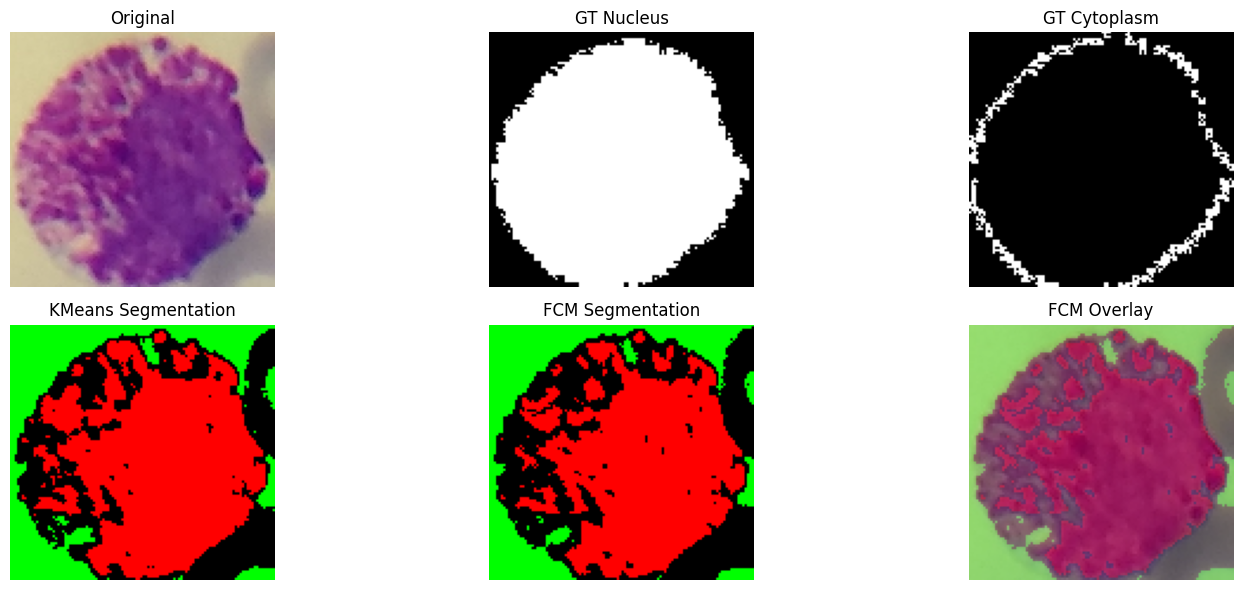

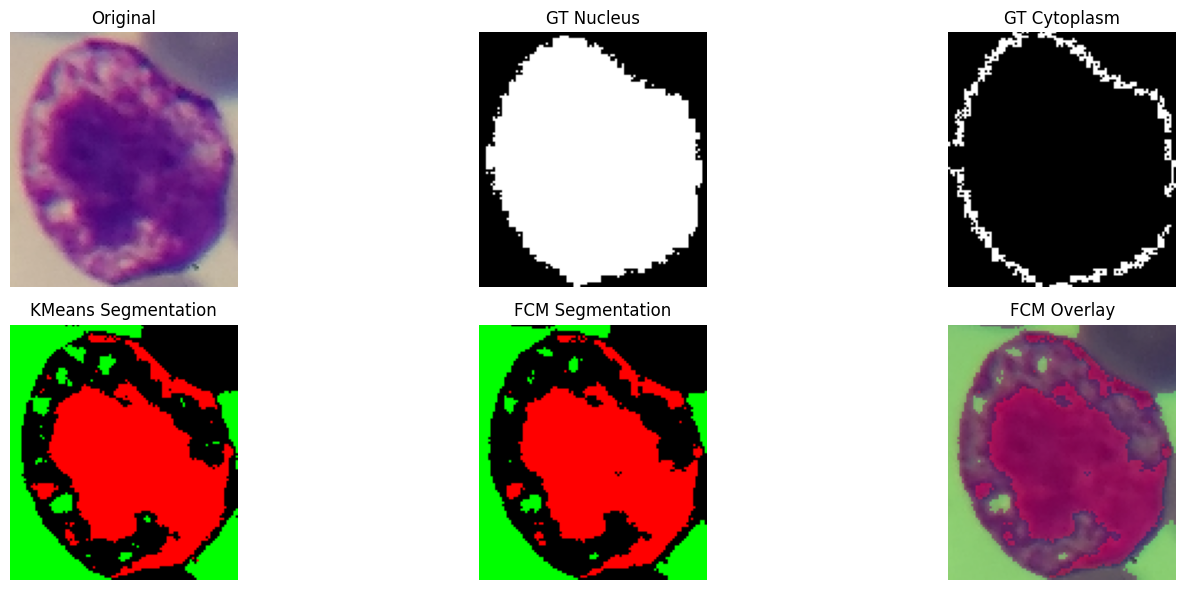

In [66]:
for f in files[:2]:
    visualize_full_segmentation(f)